In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
import scipy
import gc

from helpers import *
import epyestim
import epyestim.covid19 as covid19

today_str = dt.datetime.today().strftime('%y%m%d')

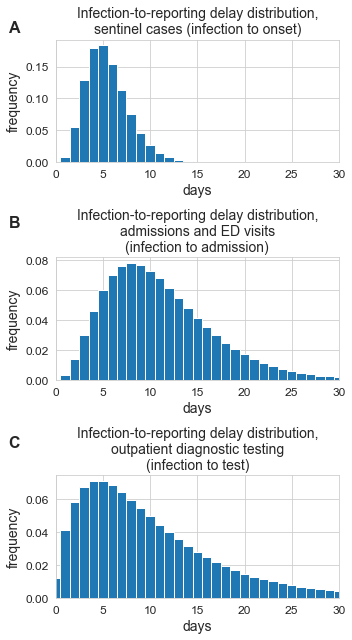

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,9))
alpha = 1
# Panel A ###################################################
my_continuous_distrb = scipy.stats.gamma(a=5.807, scale=0.948)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)
sc_distrb = my_discrete_distrb
axes[0].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[0].set_xlim([0,30])
axes[0].set_title('Infection-to-reporting delay distribution,\nsentinel cases (infection to onset)', fontsize=14)
axes[0].set_xlabel('days', fontsize=14)

# Panel B ###################################################
alpha1 = 5.807
theta1 = 0.948
#print(alpha1*theta1)
alpha2 = 1.104 #5.074 
theta2 = 5.074 #1.104
#print(alpha2*theta2)
k_sum = (alpha1*theta1 + alpha2*theta2)**2/((alpha1*theta1**2) + (alpha2*theta2**2))
theta_sum = (alpha1*theta1 + alpha2*theta2)/k_sum

k_sum = (alpha1*theta1 + alpha2*theta2)**2/((alpha1*theta1**2) + (alpha2*theta2**2))
theta_sum = (alpha1*theta1 + alpha2*theta2)/k_sum

#print(k_sum, theta_sum)
#print(k_sum*theta_sum)

my_continuous_distrb = scipy.stats.gamma(a=k_sum, scale=theta_sum)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)
#my_discrete_distrb = covid19.generate_standard_infection_to_reporting_distribution()
cli_distrb = my_discrete_distrb
axes[1].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[1].set_xlim([0,30])
axes[1].set_title('Infection-to-reporting delay distribution,\nadmissions and ED visits\n(infection to admission)', fontsize=14)
axes[1].set_xlabel('days', fontsize=14)

# Panel C ###################################################
case_distrb = covid19.generate_standard_infection_to_reporting_distribution()
my_discrete_distrb = case_distrb
axes[2].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[2].set_xlim([0,30])
axes[2].set_title('Infection-to-reporting delay distribution,\noutpatient diagnostic testing\n(infection to test)', fontsize=14)
axes[2].set_xlabel('days', fontsize=14)

#print(k_sum, theta_sum)
#print(k_sum*theta_sum)
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylabel('frequency', fontsize=14)

fig.text(y=0.95, x=0.05, s='A', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.65, x=0.05, s='B', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.31, x=0.05, s='C', va='center', ha='center', fontsize=16, weight='bold')
fig.tight_layout()

# Retrieving archived data

In [6]:
#Retrieving archived data
# CLI hospitalizations
cli = pd.read_csv('./data/CLI_admissions_210825.csv') #Good! This is actual CLI
cli['date'] = pd.to_datetime(cli['date'], utc=True)
cli_series = cli[cli['region'] == 'Chicago'].groupby('date').sum()['inpatient']

r_cli = covid19.r_covid(cli_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

# ED visits (CLI & covid-confirmed)
cli_ed = pd.read_csv('./data/ed_visits_chicago_210923.csv')
cli_ed['date'] = pd.to_datetime(cli_ed['date'], utc=True)

covid_ed_series = cli_ed.set_index('date')['total_covid_daily']
covid_ed_series = covid_ed_series.dropna()
r_covid_ed = covid19.r_covid(covid_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

cli_ed_series = cli_ed.set_index('date')['total_cli_daily']
cli_ed_series = cli_ed_series.dropna()
r_cli_ed = covid19.r_covid(cli_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

cli_cdph_series = cli_cdph.set_index('date')['hospitalizations_total']
cli_cdph_series = cli_cdph_series.dropna()

r_cli_cdph = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
#r_cli_cdph_partial = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=False)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

# cases
case_series = cli_cdph.set_index('date')['cases_total']
case_series = case_series.dropna()
r_case = covid19.r_covid(case_series, delay_distribution=case_distrb, r_window_size=14, auto_cutoff=True)

In [7]:
curative = pd.read_csv('~/Box/covid_CDPH/2021.07.06 Master Set Data Only_Deidentified.csv', encoding= 'unicode_escape')
curative['patient_symptom_date'] = pd.to_datetime(curative['patient_symptom_date'], errors='coerce')
curative['collection_time'] = pd.to_datetime(curative['collection_time'], errors='coerce')
curative['days'] = (pd.to_datetime(curative['collection_time'], utc=True) - pd.to_datetime(curative['patient_symptom_date'], utc=True)).dt.days

C:\Users\Ibis Grad\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,4,10,11,13,15,16,18,19,20,21,22,23,24,25,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
idph =  pd.read_csv('~/Box/covid_IDPH/sentinel_surveillance/210706_SS_epic.csv', encoding= 'unicode_escape')
idph['test_date'] = pd.to_datetime(idph['test_date'])
idph['test_time'] = pd.to_datetime(idph['test_time'])
idph['date_symptoms_start'] = pd.to_datetime(idph['date_symptoms_start'])
idph['days'] = (idph['test_date'] - idph['date_symptoms_start']).dt.days
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
pos_cond = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
chi_cond = (idph['test_site_city'] == 'CHICAGO')

In [9]:
zips = pd.read_csv('./data/Chicago_ZIP_codes.txt', header=None)[0].values
idph['chicago'] = idph['pat_zip_code'].apply(lambda x: zip_in_zips(x, zips))
curative['chicago'] = curative['patient_city'] == 'Chicago'

In [10]:
curative_time_frame_cond = (curative['collection_time'] >= pd.to_datetime('9-27-20')) & (curative['collection_time'] <= pd.to_datetime('6-13-21'))
curative_ss = (curative['days'] >= 0) & (curative['days'] <= 4)
curative_symptom = curative['patient_is_symptomatic']

idph_time_frame_cond = (idph['test_date'] >= pd.to_datetime('9-27-20')) & (idph['test_date'] <= pd.to_datetime('6-13-21'))
idph_ss = (idph['days'] >= 0) & (idph['days'] <= 4)
idph_symptom = idph['symptomatic_per_cdc'] == 'Yes'
idph_chicago_site = (idph['test_site'] == 'IDPH COMMUNITY TESTING AUBURN GRESHAM') | (idph['test_site'] == 'IDPH AUBURN GRESHAM COMMUNITY TESTING') | (idph['test_site'] == 'IDPH HARWOOD HEIGHTS COMMUNITY TESTING')

idph_count = np.sum(idph_time_frame_cond & idph_ss & idph['chicago'] & idph_chicago_site)
curative_count = np.sum(curative_time_frame_cond & curative_ss & curative['chicago'])

# Collecting cases

In [274]:
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['collection_date','symptom_date', 'positive'])

for date in idx:
    idph_slice = idph[ss_cond & idph['chicago'] & chi_idph & idph_chicago_site & (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'symptom_date'})
    
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'symptom_date'})
    
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['symptom_date'] = pd.to_datetime(combo_short['symptom_date'], utc=True).dt.date
    combo_short['collection_date'] = date
    all_cases = all_cases.append(combo_short)
    
all_cases['symptom_date'] = pd.to_datetime(all_cases['symptom_date'], utc=True)
all_cases['collection_date'] = pd.to_datetime(all_cases['collection_date'], utc=True)
all_cases['days'] = (all_cases['collection_date'] - all_cases['symptom_date']).dt.days

# Example fig

In [784]:
eval_date = pd.to_datetime(dt.datetime(day=25, month=11, year=2020), utc=True)
ss_last_date = eval_date - dt.timedelta(days=2)
hosp_last_date = eval_date - dt.timedelta(days=5)
train_set_window = 30
max_delay = 4
alpha_pred = 0.05

z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

all_cases_train_set = all_cases[(all_cases['collection_date'] <= ss_last_date - 
                                 dt.timedelta(days=max_delay)) &
                                (all_cases['collection_date'] >= ss_last_date - 
                                 dt.timedelta(days=train_set_window+max_delay))]

all_cases_censored = all_cases[all_cases['collection_date'] <= ss_last_date]

combo_sc = (all_cases['positive']).groupby(all_cases['symptom_date']).sum()
combo_sc_clipped = combo_sc[combo_sc.index <= ss_last_date]
combo_sc_censored = (all_cases_censored['positive']).groupby(all_cases_censored['symptom_date']).sum()
combo_sc_censored = combo_sc_censored.reindex(combo_sc[combo_sc.index <= ss_last_date].index, fill_value=0)
#sns.distplot(all_cases[all_cases['positive']]['days'])

nowcast_combo_sc = combo_sc_censored.copy()
nowcast_combo_sc_upper = combo_sc_censored.copy()
nowcast_combo_sc_lower = combo_sc_censored.copy()
for date, delay in zip(pd.date_range(ss_last_date-dt.timedelta(days=max_delay-1), ss_last_date), np.arange(3,-1,-1)):
    n_total_train_set = np.sum(all_cases_train_set['positive'])
    n_reported_train_set = np.sum(all_cases_train_set[all_cases_train_set['positive']]['days'] <= delay)
    
    if nowcast_combo_sc.loc[date] == 0:
        nowcast_combo_sc.loc[date] = 1
    if n_total_train_set == 0:
        n_total_train_set = 1  
    if n_reported_train_set == 0:
        n_reported_train_set = 1
    p = n_reported_train_set/n_total_train_set
    std_p = np.sqrt(p*(1-p)/n_total_train_set)
    nowcast_combo_sc_lower.loc[date] = nowcast_combo_sc.loc[date]*(1/(p+(z_score*std_p)))
    nowcast_combo_sc_upper.loc[date] = nowcast_combo_sc.loc[date]*(1/(p-(z_score*std_p)))
    nowcast_combo_sc.loc[date] = nowcast_combo_sc.loc[date]*(1/p)

r_combo = covid19.r_covid(combo_sc_clipped, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_combo_censored = covid19.r_covid(combo_sc_censored, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_combo_nowcast = covid19.r_covid(nowcast_combo_sc, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_cli_cdph = covid19.r_covid(cli_cdph_series[cli_cdph_series.index <= hosp_last_date], 
                             delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

DatetimeIndex(['2020-11-09 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='D')
DatetimeIndex(['2020-11-18 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='D')


meta NOT subset; don't know how to subset; dropped


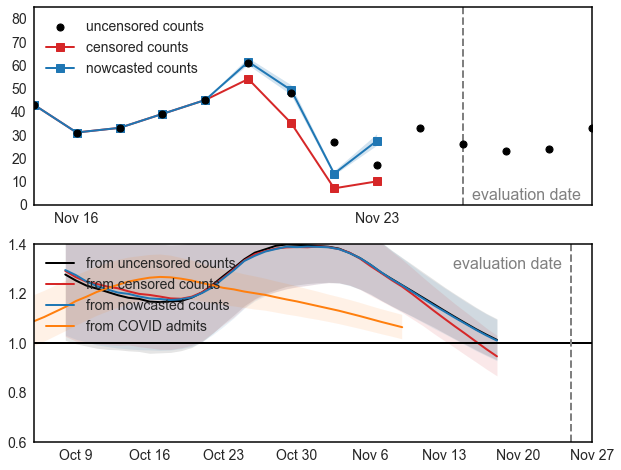

In [786]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

###### count plot
ax = axes[0]
ax.scatter(x=combo_sc.index, y=combo_sc, color='k', zorder=5, s=50, label='uncensored counts')
ax.axvline(eval_date, color='grey', linewidth=2, linestyle='dashed')
ax.text(x=eval_date, s='  evaluation date', y=2, color='grey', fontsize=16)
ax.plot(combo_sc_censored, color=sns.color_palette()[3], marker='s', linewidth=2, markersize=8, label='censored counts')
ax.plot(nowcast_combo_sc, color=sns.color_palette()[0], marker='s', linewidth=2, markersize=8, label='nowcasted counts')
ax.fill_between(x=nowcast_combo_sc_lower.index, 
                 y1=nowcast_combo_sc_lower.astype(float), 
                 y2=nowcast_combo_sc_upper.astype(float), 
                 color=sns.color_palette()[0], alpha=0.2, linewidth=0)
ax.set_xlim([ss_last_date - dt.timedelta(days=8), ss_last_date + dt.timedelta(days=5)])
ax.set_yticks(np.arange(0,100,10))
ax.set_ylim([0,85])
ax.grid(False)
leg = ax.legend(fontsize=14, loc='upper left', frameon=False)

###### R(t) plot
ax = axes[1]
disp_alpha=0.1
r = r_combo
ax.plot(r['Q0.5'], color='k', linewidth=2, label='from uncensored counts')
ax.fill_between(x=r.index, 
                y1=r['Q0.025'], 
                y2=r['Q0.975'], 
                alpha=disp_alpha, linewidth=0, color='k')

r = r_combo_censored
ax.plot(r['Q0.5'], color=sns.color_palette()[3], linewidth=2, label='from censored counts')
ax.fill_between(x=r.index, 
                y1=r['Q0.025'], 
                y2=r['Q0.975'], 
                alpha=disp_alpha, linewidth=0, color=sns.color_palette()[3])

r = r_combo_nowcast
ax.plot(r['Q0.5'], color=sns.color_palette()[0], linewidth=2, label='from nowcasted counts')
ax.fill_between(x=r.index, 
                y1=r['Q0.025'], 
                y2=r['Q0.975'], 
                alpha=disp_alpha, linewidth=0, color=sns.color_palette()[0])

r = r_cli_cdph
ax.plot(r['Q0.5'], color=sns.color_palette()[1], linewidth=2, label='from COVID admits')
ax.fill_between(x=r.index, 
                y1=r['Q0.025'], 
                y2=r['Q0.975'], 
                alpha=disp_alpha, linewidth=0, color=sns.color_palette()[1])

ax.set_xlim([eval_date - dt.timedelta(days=51), eval_date + dt.timedelta(days=2)])
ax.set_ylim([0.6,1.4])
ax.axhline(1.0, color='k', linewidth=2)
leg = ax.legend(fontsize=14, loc='upper left', frameon=False)

ax.axvline(eval_date, color='grey', linewidth=2, linestyle='dashed')
ax.text(x=eval_date, s='evaluation date  ', y=1.3, color='grey', fontsize=16, ha='right')

for ax in axes:
    for pos in ['bottom', 'left', 'top', 'right']:
        ax.spines[pos].set_linewidth(1.5)
        ax.spines[pos].set_color('k')
    ax.tick_params(labelsize=14, axis='both')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %#d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

ax.grid(False)        
print(r_cli_cdph.index[-1:])
print(r_combo_censored.index[-1:])

fig.savefig('eval_date_' + eval_date.strftime('%y%m%d') + '_nowcasting_comparison_' + today_str + '.png', 
            dpi=200, bbox_inches='tight')
fig.savefig('eval_date_' + eval_date.strftime('%y%m%d') + '_nowcasting_comparison_' + today_str + '.pdf', 
            bbox_inches='tight')

In [677]:
%%time
r_combo = covid19.r_covid(combo_sc_clipped, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_combo_censored = covid19.r_covid(combo_sc_censored, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_combo_nowcast = covid19.r_covid(nowcast_combo_sc, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_cli_cdph = covid19.r_covid(cli_cdph_series[cli_cdph_series.index <= hosp_last_date], delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

Wall time: 8.06 s


DatetimeIndex(['2021-02-22 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='D')
DatetimeIndex(['2021-03-03 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='D')


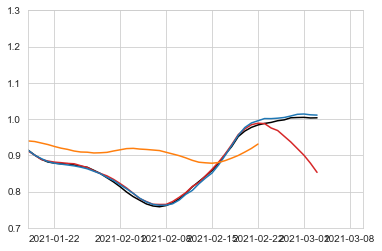

In [678]:
plt.plot(r_combo['Q0.5'], color='k')
plt.plot(r_combo_censored['Q0.5'], color=sns.color_palette()[3])
plt.plot(r_combo_nowcast['Q0.5'], color=sns.color_palette()[0])
plt.plot(r_cli_cdph['Q0.5'], color=sns.color_palette()[1])
plt.xlim([eval_date - dt.timedelta(days=51), eval_date])
plt.ylim([0.7,1.3])
print(r_cli_cdph.index[-1:])
print(r_combo_censored.index[-1:])

In [338]:
cli_cdph_series[cli_cdph_series.index]

date
2020-03-01 00:00:00+00:00     2.0
2020-03-02 00:00:00+00:00     1.0
2020-03-03 00:00:00+00:00     3.0
2020-03-04 00:00:00+00:00     2.0
2020-03-05 00:00:00+00:00     6.0
                             ... 
2021-09-14 00:00:00+00:00    30.0
2021-09-15 00:00:00+00:00    17.0
2021-09-16 00:00:00+00:00    29.0
2021-09-17 00:00:00+00:00    34.0
2021-09-18 00:00:00+00:00    20.0
Name: hospitalizations_total, Length: 567, dtype: float64

In [282]:
scipy.stats.norm.ppf(1-alpha_pred/2)

1.959963984540054

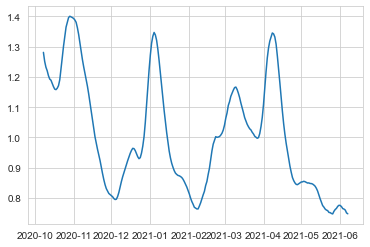

In [277]:
plt.plot(r_combo['Q0.5'])

# FPR/FNR evaluation

### Nowcasting with previous 30 day window

In [424]:
%%time

np.random.seed(30)
train_set_window = 30
max_delay = 4
alpha_pred = 0.05
z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

result_df = pd.DataFrame(columns=['eval_date', 'r_combo', 'r_combo_censored', 'r_combo_nowcast'])
for eval_date in pd.date_range('10-16-2020', '06-10-2021', freq='1D', tz='utc'):
    ss_last_date = eval_date - dt.timedelta(days=2)
    hosp_last_date = eval_date - dt.timedelta(days=5)

    z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

    all_cases_train_set = all_cases[(all_cases['collection_date'] <= ss_last_date - 
                                     dt.timedelta(days=max_delay)) &
                                    (all_cases['collection_date'] >= ss_last_date - 
                                     dt.timedelta(days=train_set_window+max_delay))]

    all_cases_censored = all_cases[all_cases['collection_date'] <= ss_last_date]

    combo_sc = (all_cases['positive']).groupby(all_cases['symptom_date']).sum()
    combo_sc_clipped = combo_sc[combo_sc.index <= ss_last_date]
    combo_sc_censored = (all_cases_censored['positive']).groupby(all_cases_censored['symptom_date']).sum()
    combo_sc_censored = combo_sc_censored.reindex(combo_sc[combo_sc.index <= ss_last_date].index, fill_value=0)
    #sns.distplot(all_cases[all_cases['positive']]['days'])

    nowcast_combo_sc = combo_sc_censored.copy()
    nowcast_combo_sc_upper = combo_sc_censored.copy()
    nowcast_combo_sc_lower = combo_sc_censored.copy()
    for date, delay in zip(pd.date_range(ss_last_date-dt.timedelta(days=max_delay-1), ss_last_date), np.arange(3,-1,-1)):
        n_total_train_set = np.sum(all_cases_train_set['positive'])
        n_reported_train_set = np.sum(all_cases_train_set[all_cases_train_set['positive']]['days'] <= delay)

        if nowcast_combo_sc.loc[date] == 0:
            nowcast_combo_sc.loc[date] = 1
        if n_total_train_set == 0:
            n_total_train_set = 1  
        if n_reported_train_set == 0:
            n_reported_train_set = 1
        p = n_reported_train_set/n_total_train_set
        nowcast_combo_sc.loc[date] = nowcast_combo_sc.loc[date]*(1/p)

    r_combo = covid19.r_covid(combo_sc_clipped, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_combo_censored = covid19.r_covid(combo_sc_censored, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_combo_nowcast = covid19.r_covid(nowcast_combo_sc, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    result_df = result_df.append(pd.DataFrame({'eval_date':[eval_date], 
                                               'r_combo':[r_combo['Q0.5'].values[-1]], 
                                               'r_combo_censored':[r_combo_censored['Q0.5'].values[-1]], 
                                               'r_combo_nowcast':[r_combo_nowcast['Q0.5'].values[-1]]}))

Wall time: 20min 10s


In [477]:
result_df = result_df[result_df['eval_date'] <= pd.to_datetime('2021-06-10', utc=True)]
result_df.to_csv(today_str + '_r_combo_nowcast_past_30_days.csv', index=False)

In [479]:
neg = result_df['r_combo'] < 1
pos = result_df['r_combo'] >= 1
censor_neg = result_df['r_combo_censored'] < 1
censor_pos = result_df['r_combo_censored'] >= 1
nowcast_neg = result_df['r_combo_nowcast'] < 1
nowcast_pos = result_df['r_combo_nowcast'] >= 1

n_pos = np.sum(pos)
n_neg = np.sum(neg)
n_fp_censor = np.sum(censor_pos & neg)
n_fn_censor = np.sum(censor_neg & pos)
n_fp_nowcast = np.sum(nowcast_pos & neg)
n_fn_nowcast = np.sum(nowcast_neg & pos)

fpr_fnr_df = pd.DataFrame({'method':['30-day'], 
                  'n_pos':[n_pos], 
                  'n_neg':[n_neg], 
                  'n_fp_censor':[n_fp_censor], 
                  'n_fn_censor':[n_fn_censor], 
                  'n_fp_nowcast':[n_fp_nowcast], 
                  'n_fn_nowcast':[n_fn_nowcast]})

fpr_fnr_df.to_csv(today_str + '_r_combo_nowcast_past_30_days_fpr_table.csv', index=False)

### Nowcasting with all previous data

In [480]:
%%time

np.random.seed(30)
train_set_window = 1000
max_delay = 4
alpha_pred = 0.05
z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

result_df = pd.DataFrame(columns=['eval_date', 'r_combo', 'r_combo_censored', 'r_combo_nowcast'])
for eval_date in pd.date_range('10-16-2020', '06-10-2021', freq='1D', tz='utc'):
    print(eval_date)
    ss_last_date = eval_date - dt.timedelta(days=2)
    hosp_last_date = eval_date - dt.timedelta(days=5)

    z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

    all_cases_train_set = all_cases[(all_cases['collection_date'] <= ss_last_date - 
                                     dt.timedelta(days=max_delay)) &
                                    (all_cases['collection_date'] >= ss_last_date - 
                                     dt.timedelta(days=train_set_window+max_delay))]

    all_cases_censored = all_cases[all_cases['collection_date'] <= ss_last_date]

    combo_sc = (all_cases['positive']).groupby(all_cases['symptom_date']).sum()
    combo_sc_clipped = combo_sc[combo_sc.index <= ss_last_date]
    combo_sc_censored = (all_cases_censored['positive']).groupby(all_cases_censored['symptom_date']).sum()
    combo_sc_censored = combo_sc_censored.reindex(combo_sc[combo_sc.index <= ss_last_date].index, fill_value=0)
    #sns.distplot(all_cases[all_cases['positive']]['days'])

    nowcast_combo_sc = combo_sc_censored.copy()
    nowcast_combo_sc_upper = combo_sc_censored.copy()
    nowcast_combo_sc_lower = combo_sc_censored.copy()
    for date, delay in zip(pd.date_range(ss_last_date-dt.timedelta(days=max_delay-1), ss_last_date), np.arange(3,-1,-1)):
        n_total_train_set = np.sum(all_cases_train_set['positive'])
        n_reported_train_set = np.sum(all_cases_train_set[all_cases_train_set['positive']]['days'] <= delay)

        if nowcast_combo_sc.loc[date] == 0:
            nowcast_combo_sc.loc[date] = 1
        if n_total_train_set == 0:
            n_total_train_set = 1  
        if n_reported_train_set == 0:
            n_reported_train_set = 1
        p = n_reported_train_set/n_total_train_set
        nowcast_combo_sc.loc[date] = nowcast_combo_sc.loc[date]*(1/p)

    r_combo = covid19.r_covid(combo_sc_clipped, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_combo_censored = covid19.r_covid(combo_sc_censored, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_combo_nowcast = covid19.r_covid(nowcast_combo_sc, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    result_df = result_df.append(pd.DataFrame({'eval_date':[eval_date], 
                                               'r_combo':[r_combo['Q0.5'].values[-1]], 
                                               'r_combo_censored':[r_combo_censored['Q0.5'].values[-1]], 
                                               'r_combo_nowcast':[r_combo_nowcast['Q0.5'].values[-1]]}))

2020-10-16 00:00:00+00:00
2020-10-17 00:00:00+00:00
2020-10-18 00:00:00+00:00
2020-10-19 00:00:00+00:00
2020-10-20 00:00:00+00:00
2020-10-21 00:00:00+00:00
2020-10-22 00:00:00+00:00
2020-10-23 00:00:00+00:00
2020-10-24 00:00:00+00:00
2020-10-25 00:00:00+00:00
2020-10-26 00:00:00+00:00
2020-10-27 00:00:00+00:00
2020-10-28 00:00:00+00:00
2020-10-29 00:00:00+00:00
2020-10-30 00:00:00+00:00
2020-10-31 00:00:00+00:00
2020-11-01 00:00:00+00:00
2020-11-02 00:00:00+00:00
2020-11-03 00:00:00+00:00
2020-11-04 00:00:00+00:00
2020-11-05 00:00:00+00:00
2020-11-06 00:00:00+00:00
2020-11-07 00:00:00+00:00
2020-11-08 00:00:00+00:00
2020-11-09 00:00:00+00:00
2020-11-10 00:00:00+00:00
2020-11-11 00:00:00+00:00
2020-11-12 00:00:00+00:00
2020-11-13 00:00:00+00:00
2020-11-14 00:00:00+00:00
2020-11-15 00:00:00+00:00
2020-11-16 00:00:00+00:00
2020-11-17 00:00:00+00:00
2020-11-18 00:00:00+00:00
2020-11-19 00:00:00+00:00
2020-11-20 00:00:00+00:00
2020-11-21 00:00:00+00:00
2020-11-22 00:00:00+00:00
2020-11-23 0

In [481]:
result_df = result_df[result_df['eval_date'] <= pd.to_datetime('2021-06-10', utc=True)]
result_df.to_csv(today_str + '_r_combo_nowcast_all_data.csv', index=False)

In [483]:
neg = result_df['r_combo'] < 1
pos = result_df['r_combo'] >= 1
censor_neg = result_df['r_combo_censored'] < 1
censor_pos = result_df['r_combo_censored'] >= 1
nowcast_neg = result_df['r_combo_nowcast'] < 1
nowcast_pos = result_df['r_combo_nowcast'] >= 1

n_pos = np.sum(pos)
n_neg = np.sum(neg)
n_fp_censor = np.sum(censor_pos & neg)
n_fn_censor = np.sum(censor_neg & pos)
n_fp_nowcast = np.sum(nowcast_pos & neg)
n_fn_nowcast = np.sum(nowcast_neg & pos)

fpr_fnr_df = pd.DataFrame({'method':['all data'], 
                  'n_pos':[n_pos], 
                  'n_neg':[n_neg], 
                  'n_fp_censor':[n_fp_censor], 
                  'n_fn_censor':[n_fn_censor], 
                  'n_fp_nowcast':[n_fp_nowcast], 
                  'n_fn_nowcast':[n_fn_nowcast]})

fpr_fnr_df.to_csv(today_str + '_r_combo_nowcast_all_data.csv', index=False)

### Nowcasting with all previous data (on appropriate day of week)

In [503]:
%%time

np.random.seed(30)
train_set_window = 1000
max_delay = 4
alpha_pred = 0.05
z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

result_df = pd.DataFrame(columns=['eval_date', 'r_combo', 'r_combo_censored', 'r_combo_nowcast'])
for eval_date in pd.date_range('10-16-2020', '06-10-2021', freq='1D', tz='utc'):
    print(eval_date)
    ss_last_date = eval_date - dt.timedelta(days=2)
    hosp_last_date = eval_date - dt.timedelta(days=5)

    z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

    all_cases_train_set = all_cases[(all_cases['collection_date'] <= ss_last_date - 
                                     dt.timedelta(days=max_delay)) &
                                    (all_cases['collection_date'] >= ss_last_date - 
                                     dt.timedelta(days=train_set_window+max_delay))]
    all_cases_train_set = all_cases_train_set[all_cases_train_set['symptom_date'].dt.dayofweek == eval_date.dayofweek]

    all_cases_censored = all_cases[all_cases['collection_date'] <= ss_last_date]

    combo_sc = (all_cases['positive']).groupby(all_cases['symptom_date']).sum()
    combo_sc_clipped = combo_sc[combo_sc.index <= ss_last_date]
    combo_sc_censored = (all_cases_censored['positive']).groupby(all_cases_censored['symptom_date']).sum()
    combo_sc_censored = combo_sc_censored.reindex(combo_sc[combo_sc.index <= ss_last_date].index, fill_value=0)
    #sns.distplot(all_cases[all_cases['positive']]['days'])

    nowcast_combo_sc = combo_sc_censored.copy()
    nowcast_combo_sc_upper = combo_sc_censored.copy()
    nowcast_combo_sc_lower = combo_sc_censored.copy()
    for date, delay in zip(pd.date_range(ss_last_date-dt.timedelta(days=max_delay-1), ss_last_date), np.arange(3,-1,-1)):
        n_total_train_set = np.sum(all_cases_train_set['positive'])
        n_reported_train_set = np.sum(all_cases_train_set[all_cases_train_set['positive']]['days'] <= delay)

        if nowcast_combo_sc.loc[date] == 0:
            nowcast_combo_sc.loc[date] = 1
        if n_total_train_set == 0:
            n_total_train_set = 1  
        if n_reported_train_set == 0:
            n_reported_train_set = 1
        p = n_reported_train_set/n_total_train_set
        nowcast_combo_sc.loc[date] = nowcast_combo_sc.loc[date]*(1/p)

    r_combo = covid19.r_covid(combo_sc_clipped, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_combo_censored = covid19.r_covid(combo_sc_censored, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_combo_nowcast = covid19.r_covid(nowcast_combo_sc, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    result_df = result_df.append(pd.DataFrame({'eval_date':[eval_date], 
                                               'r_combo':[r_combo['Q0.5'].values[-1]], 
                                               'r_combo_censored':[r_combo_censored['Q0.5'].values[-1]], 
                                               'r_combo_nowcast':[r_combo_nowcast['Q0.5'].values[-1]]}))

2020-10-16 00:00:00+00:00
2020-10-17 00:00:00+00:00
2020-10-18 00:00:00+00:00
2020-10-19 00:00:00+00:00
2020-10-20 00:00:00+00:00
2020-10-21 00:00:00+00:00
2020-10-22 00:00:00+00:00
2020-10-23 00:00:00+00:00
2020-10-24 00:00:00+00:00
2020-10-25 00:00:00+00:00
2020-10-26 00:00:00+00:00
2020-10-27 00:00:00+00:00
2020-10-28 00:00:00+00:00
2020-10-29 00:00:00+00:00
2020-10-30 00:00:00+00:00
2020-10-31 00:00:00+00:00
2020-11-01 00:00:00+00:00
2020-11-02 00:00:00+00:00
2020-11-03 00:00:00+00:00
2020-11-04 00:00:00+00:00
2020-11-05 00:00:00+00:00
2020-11-06 00:00:00+00:00
2020-11-07 00:00:00+00:00
2020-11-08 00:00:00+00:00
2020-11-09 00:00:00+00:00
2020-11-10 00:00:00+00:00
2020-11-11 00:00:00+00:00
2020-11-12 00:00:00+00:00
2020-11-13 00:00:00+00:00
2020-11-14 00:00:00+00:00
2020-11-15 00:00:00+00:00
2020-11-16 00:00:00+00:00
2020-11-17 00:00:00+00:00
2020-11-18 00:00:00+00:00
2020-11-19 00:00:00+00:00
2020-11-20 00:00:00+00:00
2020-11-21 00:00:00+00:00
2020-11-22 00:00:00+00:00
2020-11-23 0

In [504]:
result_df = result_df[result_df['eval_date'] <= pd.to_datetime('2021-06-10', utc=True)]
result_df.to_csv(today_str + '_r_combo_nowcast_day_of_week.csv', index=False)

In [510]:
neg = result_df['r_combo'] < 1
pos = result_df['r_combo'] >= 1
censor_neg = result_df['r_combo_censored'] < 1
censor_pos = result_df['r_combo_censored'] >= 1
nowcast_neg = result_df['r_combo_nowcast'] < 1
nowcast_pos = result_df['r_combo_nowcast'] >= 1

n_pos = np.sum(pos)
n_neg = np.sum(neg)
n_fp_censor = np.sum(censor_pos & neg)
n_fn_censor = np.sum(censor_neg & pos)
n_fp_nowcast = np.sum(nowcast_pos & neg)
n_fn_nowcast = np.sum(nowcast_neg & pos)

fpr_fnr_df = pd.DataFrame({'method':['day of week'], 
                  'n_pos':[n_pos], 
                  'n_neg':[n_neg], 
                  'n_fp_censor':[n_fp_censor], 
                  'n_fn_censor':[n_fn_censor], 
                  'n_fp_nowcast':[n_fp_nowcast], 
                  'n_fn_nowcast':[n_fn_nowcast]})

fpr_fnr_df.to_csv(today_str + '_r_combo_nowcast_day_of_week.csv', index=False)

In [576]:
fpr_fnr_df = pd.concat([pd.read_csv('220327_r_combo_nowcast_past_30_days_fpr_table.csv'),
                        pd.read_csv('220327_r_combo_nowcast_all_data.csv'),
                        pd.read_csv('220327_r_combo_nowcast_day_of_week.csv')])

alpha_pred = 0.05
z_score = scipy.stats.norm.ppf(1-alpha_pred/2)

fpr_censor = fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_fp_censor'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_neg'].values[0]
fpr_censor_std = np.sqrt(fpr_censor*(1-fpr_censor)/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_neg'].values[0])
fnr_censor = fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_fn_censor'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_pos'].values[0]
fnr_censor_std = np.sqrt(fnr_censor*(1-fnr_censor)/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_pos'].values[0])

fpr_nowcast_30 = fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_fp_nowcast'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_neg'].values[0]
fpr_nowcast_30_std = np.sqrt(fpr_nowcast_30*(1-fpr_nowcast_30)/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_neg'].values[0])
fnr_nowcast_30 = fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_fn_nowcast'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_pos'].values[0]
fnr_nowcast_30_std = np.sqrt(fnr_nowcast_30*(1-fnr_nowcast_30)/fpr_fnr_df.loc[fpr_fnr_df['method'] == '30-day']['n_pos'].values[0])

fpr_nowcast_all = fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_fp_nowcast'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_neg'].values[0]
fpr_nowcast_all_std = np.sqrt(fpr_nowcast_all*(1-fpr_nowcast_30)/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_neg'].values[0])
fnr_nowcast_all = fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_fn_nowcast'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_pos'].values[0]
fnr_nowcast_all_std = np.sqrt(fnr_nowcast_all*(1-fnr_nowcast_30)/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_pos'].values[0])

fpr_nowcast_dow = fpr_fnr_df.loc[fpr_fnr_df['method'] == 'day of week']['n_fp_nowcast'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_neg'].values[0]
fpr_nowcast_dow_std = np.sqrt(fpr_nowcast_dow*(1-fpr_nowcast_30)/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_neg'].values[0])
fnr_nowcast_dow = fpr_fnr_df.loc[fpr_fnr_df['method'] == 'day of week']['n_fn_nowcast'].values[0]/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_pos'].values[0]
fnr_nowcast_dow_std = np.sqrt(fnr_nowcast_dow*(1-fnr_nowcast_30)/fpr_fnr_df.loc[fpr_fnr_df['method'] == 'all data']['n_pos'].values[0])

meta NOT subset; don't know how to subset; dropped


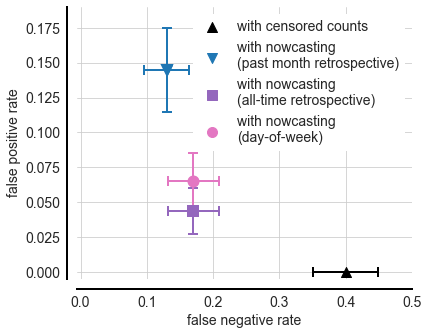

In [775]:
fig = plt.figure(figsize=(6,5))
ax = plt.gca()
ax.scatter(fnr_censor, fpr_censor,  
             marker="^",
             s=100, 
             color='k', label='with censored counts')

ax.scatter(fnr_nowcast_30, fpr_nowcast_30,  
             marker="v",
             s=100, 
             color=sns.color_palette()[0], label='with nowcasting\n(past month retrospective)')

ax.scatter(fnr_nowcast_all, fpr_nowcast_all,  
             marker="s",
             s=100, 
             color=sns.color_palette()[4], label='with nowcasting\n(all-time retrospective)')

ax.scatter(fnr_nowcast_dow, fpr_nowcast_dow,  
             marker="o",
             s=100, 
             color=sns.color_palette()[6], label='with nowcasting\n(day-of-week)')

ax.errorbar(fnr_censor, fpr_censor, 
             xerr=fnr_censor_std, 
             yerr=fpr_censor_std, 
             fmt="v",
             markersize=1, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color='k')

ax.errorbar(fnr_nowcast_30, fpr_nowcast_30, 
             xerr=fnr_nowcast_30_std, 
             yerr=fpr_nowcast_30_std, 
             fmt="v",
             markersize=10, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color=sns.color_palette()[0])

ax.errorbar(fnr_nowcast_all, fpr_nowcast_all, 
             xerr=fnr_nowcast_all_std, 
             yerr=fpr_nowcast_all_std, 
             fmt="s", 
             markersize=10, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color=sns.color_palette()[4])

ax.errorbar(fnr_nowcast_dow, fpr_nowcast_dow, 
             xerr=fnr_nowcast_dow_std, 
             yerr=fpr_nowcast_dow_std, 
             fmt="o",
             markersize=10, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color=sns.color_palette()[6])

ax.set_xlim([-0.005,0.5])
ax.set_ylim([-0.005,0.19])
leg = ax.legend(fontsize=14, loc='upper right', framealpha=1)
leg.get_frame().set_linewidth(0.0)
ax.tick_params(labelsize=14, axis='both')

ax.set_xlabel('false negative rate', fontsize=14)
ax.set_ylabel('false positive rate', fontsize=14)
for pos in ['bottom', 'left', 'top', 'right']:
    ax.spines[pos].set_linewidth(2)
    ax.spines[pos].set_color('k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

fig.savefig('fpr_fnr_nowcasting_model_comparison_' + today_str + '.png', 
            dpi=200, bbox_inches='tight')
fig.savefig('fpr_fnr_nowcasting_model_comparison_' + today_str + '.pdf', 
            bbox_inches='tight')

<ErrorbarContainer object of 3 artists>

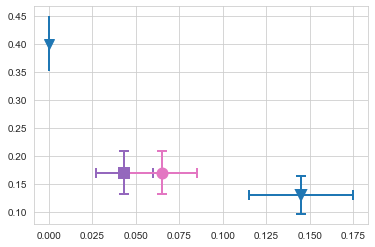

In [593]:
plt.errorbar(fpr_censor, fnr_censor, 
             xerr=fpr_censor_std, 
             yerr=fnr_censor_std, 
             fmt="v",
             markersize=10, 
             linewidth=2,
             color=sns.color_palette()[0])

plt.errorbar(fpr_nowcast_30, fnr_nowcast_30, 
             xerr=fpr_nowcast_30_std, 
             yerr=fnr_nowcast_30_std, 
             fmt="v",
             markersize=10, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color=sns.color_palette()[0], label='nowcasting (past month retrospective model)')

plt.errorbar(fpr_nowcast_all, fnr_nowcast_all, 
             xerr=fpr_nowcast_all_std, 
             yerr=fnr_nowcast_all_std, 
             fmt="s", 
             markersize=10, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color=sns.color_palette()[4], label='nowcasting (all-time retrospective model)')

plt.errorbar(fpr_nowcast_dow, fnr_nowcast_dow, 
             xerr=fpr_nowcast_dow_std, 
             yerr=fnr_nowcast_dow_std, 
             fmt="o",
             markersize=10, 
             linewidth=2, capsize=5, markeredgewidth=2,
             color=sns.color_palette()[6], label='nowcasting (day-of-week model)')

In [575]:
fpr_fnr_df

,method,n_pos,n_neg,n_fp_censor,n_fn_censor,n_fp_nowcast,n_fn_nowcast
0,30-day,100,138,0,40,20,13
0,all data,100,138,0,42,6,17
0,day of week,99,139,0,41,9,17


(30.0, 170.0)

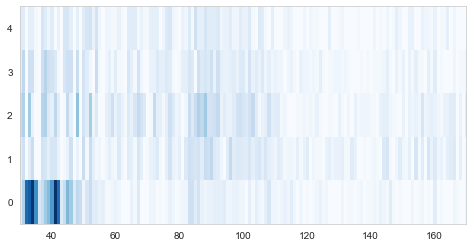

In [126]:
plt.figure(figsize=(8,4))
c_table = all_cases[all_cases['positive']].groupby(['collection_date', 'days']).size().unstack(fill_value=0).T
plt.imshow(c_table, 
           interpolation='none', aspect='auto', cmap='Blues')
plt.grid(False)
plt.ylim([-0.5,4.5])
plt.xlim([30,170])

In [148]:
all_cases_train_set[all_cases_train_set['positive']].groupby(['symptom_date', 'days']).size().unstack(fill_value=0)

days,0,1,2,3,4
symptom_date,,,,,
2021-02-13 00:00:00+00:00,0,0,0,0,1
2021-02-14 00:00:00+00:00,0,0,0,2,1
2021-02-15 00:00:00+00:00,0,0,1,1,0
2021-02-16 00:00:00+00:00,0,2,3,4,0
2021-02-17 00:00:00+00:00,1,1,1,1,0
2021-02-18 00:00:00+00:00,2,1,0,0,4
2021-02-19 00:00:00+00:00,3,0,0,1,0
2021-02-20 00:00:00+00:00,1,3,1,1,0
2021-02-21 00:00:00+00:00,2,4,1,2,1


<AxesSubplot:xlabel='days'>

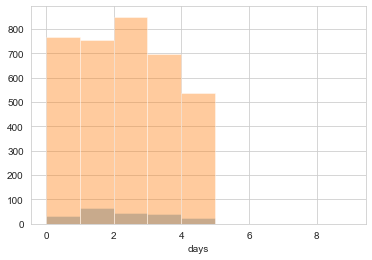

In [153]:
sns.distplot(all_cases_train_set[all_cases_train_set['positive']]['days'], bins=np.arange(0,10), kde=False)
sns.distplot(all_cases[all_cases['positive']]['days'], bins=np.arange(0,10), kde=False)

In [169]:
n_total_train_set = all_cases_train_set[all_cases_train_set['positive']]
delay = 0
n_reported_train_set = np.sum(all_cases_train_set[all_cases_train_set['positive']]['days'] <= delay)

In [170]:
n_reported_train_set

34

In [171]:
n_total_train_set

,collection_date,symptom_date,positive,days
286895,2021-02-17 00:00:00+00:00,2021-02-15 00:00:00+00:00,True,2
286546,2021-02-17 00:00:00+00:00,2021-02-16 00:00:00+00:00,True,1
286140,2021-02-17 00:00:00+00:00,2021-02-17 00:00:00+00:00,True,0
380347,2021-02-17 00:00:00+00:00,2021-02-14 00:00:00+00:00,True,3
380129,2021-02-17 00:00:00+00:00,2021-02-14 00:00:00+00:00,True,3
...,...,...,...,...
320711,2021-03-19 00:00:00+00:00,2021-03-16 00:00:00+00:00,True,3
320771,2021-03-19 00:00:00+00:00,2021-03-17 00:00:00+00:00,True,2
320774,2021-03-19 00:00:00+00:00,2021-03-17 00:00:00+00:00,True,2
394070,2021-03-19 00:00:00+00:00,2021-03-15 00:00:00+00:00,True,4


In [174]:
pd.date_range(ss_last_date-dt.timedelta(days=max_delay-1), ss_last_date)

DatetimeIndex(['2021-03-20 00:00:00+00:00', '2021-03-21 00:00:00+00:00',
               '2021-03-22 00:00:00+00:00', '2021-03-23 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

In [186]:
np.arange(3,-1,-1)

array([3, 2, 1, 0])

In [198]:
combo_sc.copy()

symptom_date
2020-09-24 00:00:00+00:00    1
2020-09-25 00:00:00+00:00    2
2020-09-26 00:00:00+00:00    4
2020-09-27 00:00:00+00:00    3
2020-09-28 00:00:00+00:00    4
                            ..
2021-06-08 00:00:00+00:00    1
2021-06-09 00:00:00+00:00    1
2021-06-10 00:00:00+00:00    1
2021-06-11 00:00:00+00:00    0
2021-06-12 00:00:00+00:00    0
Name: positive, Length: 262, dtype: int64

In [197]:
combo_sc

symptom_date
2020-09-24 00:00:00+00:00    1
2020-09-25 00:00:00+00:00    2
2020-09-26 00:00:00+00:00    4
2020-09-27 00:00:00+00:00    3
2020-09-28 00:00:00+00:00    4
                            ..
2021-06-08 00:00:00+00:00    1
2021-06-09 00:00:00+00:00    1
2021-06-10 00:00:00+00:00    1
2021-06-11 00:00:00+00:00    0
2021-06-12 00:00:00+00:00    0
Name: positive, Length: 262, dtype: int64